In [1]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import pickle
from tqdm import tqdm
import gait

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
image_vec_shape = 12
gait_key_poses = 16
conditional_vec_shape = 10
pose_image_shape = (160,160,1)
batch_size = 50
full_vec_shape = image_vec_shape+conditional_vec_shape
n_timesteps = 3
angle = '090'

In [3]:
model_OneRNN = keras.models.Sequential()
model_BiRNN = keras.models.Sequential()
model_ConvRNN = keras.models.Sequential()

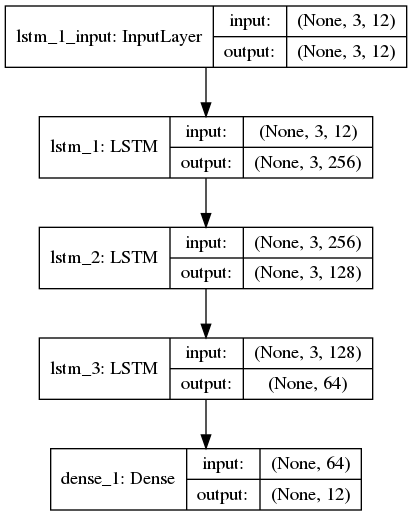

In [4]:
model_OneRNN = keras.models.Sequential()
model_OneRNN.add(keras.layers.LSTM(256,
                                   activation='tanh',
                                   return_sequences=True,
                                   input_shape=(n_timesteps,
                                                image_vec_shape)
                                  ))
#model_OneRNN.add(keras.layers.LSTM(256,
#                                   activation='tanh',
#                                   return_sequences=True
#                                  ))
model_OneRNN.add(keras.layers.LSTM(128,
                                   activation='tanh',
                                   return_sequences=True
                                  ))
model_OneRNN.add(keras.layers.LSTM(64,
                                   activation='tanh'
                                  ))
model_OneRNN.add(keras.layers.Dense(image_vec_shape,
                                    activation='linear'
                                  ))
model_OneRNN.compile(optimizer='adam', loss='mse')
plot_model(model_OneRNN, to_file='model_OneRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_OneRNN_plot.png')
im

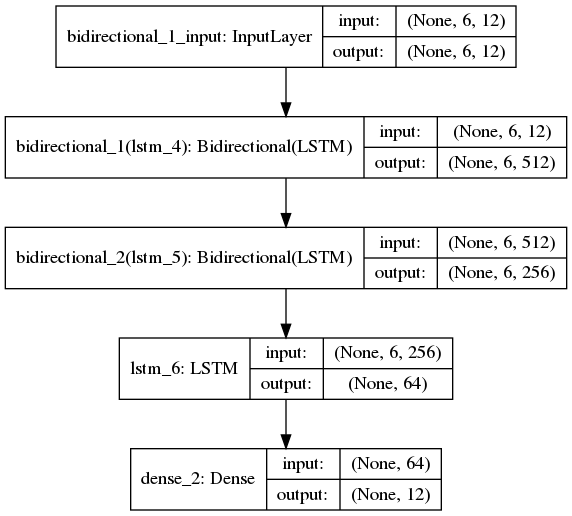

In [5]:
model_BiRNN = keras.models.Sequential()
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(256,
                                      activation='tanh',
                                      return_sequences=True),
                                      input_shape=(2*n_timesteps,image_vec_shape)
                ))
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(128,
                                      activation='tanh',
                                      return_sequences=True)
                ))
model_BiRNN.add(keras.layers.LSTM(64,
                                  activation='tanh'
                                 ))
model_BiRNN.add(keras.layers.Dense(image_vec_shape))
model_BiRNN.compile(optimizer='adam', loss='mse')
plot_model(model_BiRNN, to_file='model_BiRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_BiRNN_plot.png')
im

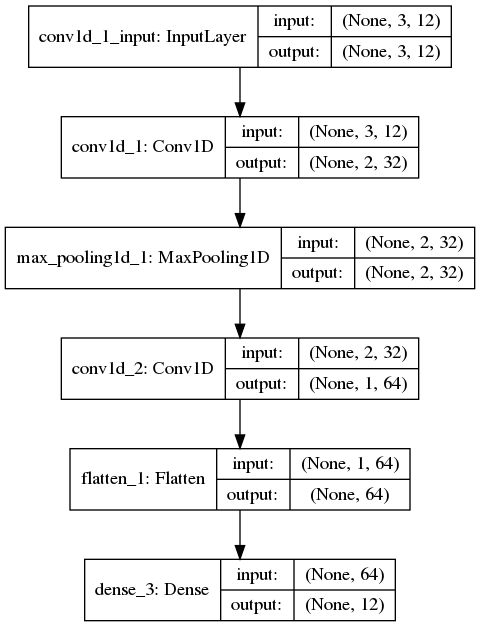

In [6]:
model_ConvRNN = keras.models.Sequential()
model_ConvRNN.add(keras.layers.Conv1D(filters=32,
                                        kernel_size = 2,
                                        activation='tanh',
                                        input_shape=(n_timesteps, image_vec_shape)
                                     ))
model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=1))
model_ConvRNN.add(keras.layers.Conv1D(filters=64,
                                      kernel_size= 2,
                                      activation='tanh'))
#model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_ConvRNN.add(keras.layers.Flatten())
model_ConvRNN.add(keras.layers.Dense(image_vec_shape))
model_ConvRNN.compile(optimizer='adam', loss='mse')
plot_model(model_ConvRNN, to_file='model_ConvRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_ConvRNN_plot.png')
im

In [7]:
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, image_vec_shape), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.)*eps
def encoder_model():
    x_in = keras.layers.Input(name="x_image",
                              shape=pose_image_shape)
    condition_in = keras.layers.Input(name="condition_hotshot",
                                      shape=(gait_key_poses,))
    condi_vec1 = keras.layers.Dense(8,activation='relu',name="condition_dense_1")(condition_in)
    condi_vec = keras.layers.Dense(4,activation='relu',name="condition_dense_2")(condi_vec1)
    x = keras.layers.Conv2D(filters=16,
                            kernel_size=(5,5),
                            strides=(3,3),
                            activation='relu',
                            name="x_conv_1")(x_in)
    x = keras.layers.BatchNormalization(name="x_batch_norm_1")(x,training=True)
    x = keras.layers.Conv2D(filters=32,
                            kernel_size=(5,5),
                            strides=(3,3),
                            activation='relu',
                            name="x_conv_2")(x)
    x = keras.layers.BatchNormalization(name="x_batch_norm_2")(x, training=True)
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(5,5),
                            strides=(3,3),
                            activation='relu',
                            name='x_conv_3')(x)
    x = keras.layers.BatchNormalization(name="x_batch_norm_3")(x, training=True)
    x = keras.layers.Flatten(name="x_flatten")(x)
    x = keras.layers.Dense(336, activation='relu',name="x_dense_final")(x)
    x_vec = keras.layers.concatenate([x,condi_vec], name="concat_xvec")
    x_vec = keras.layers.Dense(32, activation='relu',name="xvec_dense_final")(x_vec)
    mu = keras.layers.Dense(image_vec_shape, activation='linear',name="mu_dense")(x_vec)
    log_var = keras.layers.Dense(image_vec_shape, activation='linear', name="logvar_dense")(x_vec)
    z = keras.layers.Lambda(sampling, output_shape=(image_vec_shape,), name="lambda_sampling")([mu,log_var])
    z_cond = keras.layers.concatenate([z, condi_vec],name="concat_zcond")
    
    encoder = keras.models.Model([x_in,condition_in], z_cond)
    
    z1 = keras.layers.Dense(32, activation='relu', name="z_dense_1")(z_cond)
    z1 = keras.layers.Dense(336, activation='relu', name="z_dense_2")(z1)
    z1 = keras.layers.Dense(1024, activation='relu', name="z_dense_3")(z1)
    zim = keras.layers.Reshape((4,4,64),name="reshape_image")(z1)
    zim = keras.layers.Conv2DTranspose(filters=32,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_1")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_1")(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=16,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_2")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_2")(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=8,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_3")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_3")(zim, training=True)
    y = keras.layers.Conv2D(filters=1,
                            kernel_size=(1,1),
                            activation='tanh',
                            name="image_out")(zim)
    
    #decoder = keras.models.Model(z_cond_in, y)
    full_model = keras.models.Model([x_in, condition_in], y)
    
    reconstruction_loss = K.sum(K.sum(keras.losses.binary_crossentropy(x_in, y), axis=1),axis=1)
    kl_loss = 0.5*K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis=-1)
    cvae_loss = reconstruction_loss + kl_loss
    
    full_model.add_loss(cvae_loss)
    full_model.compile(optimizer='adam', loss=None)
    ## Ignore the missing from loss dictionary error
    return encoder, full_model
CVAE, CVAE_FULL = encoder_model()

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Output "image_out" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "image_out" during training.


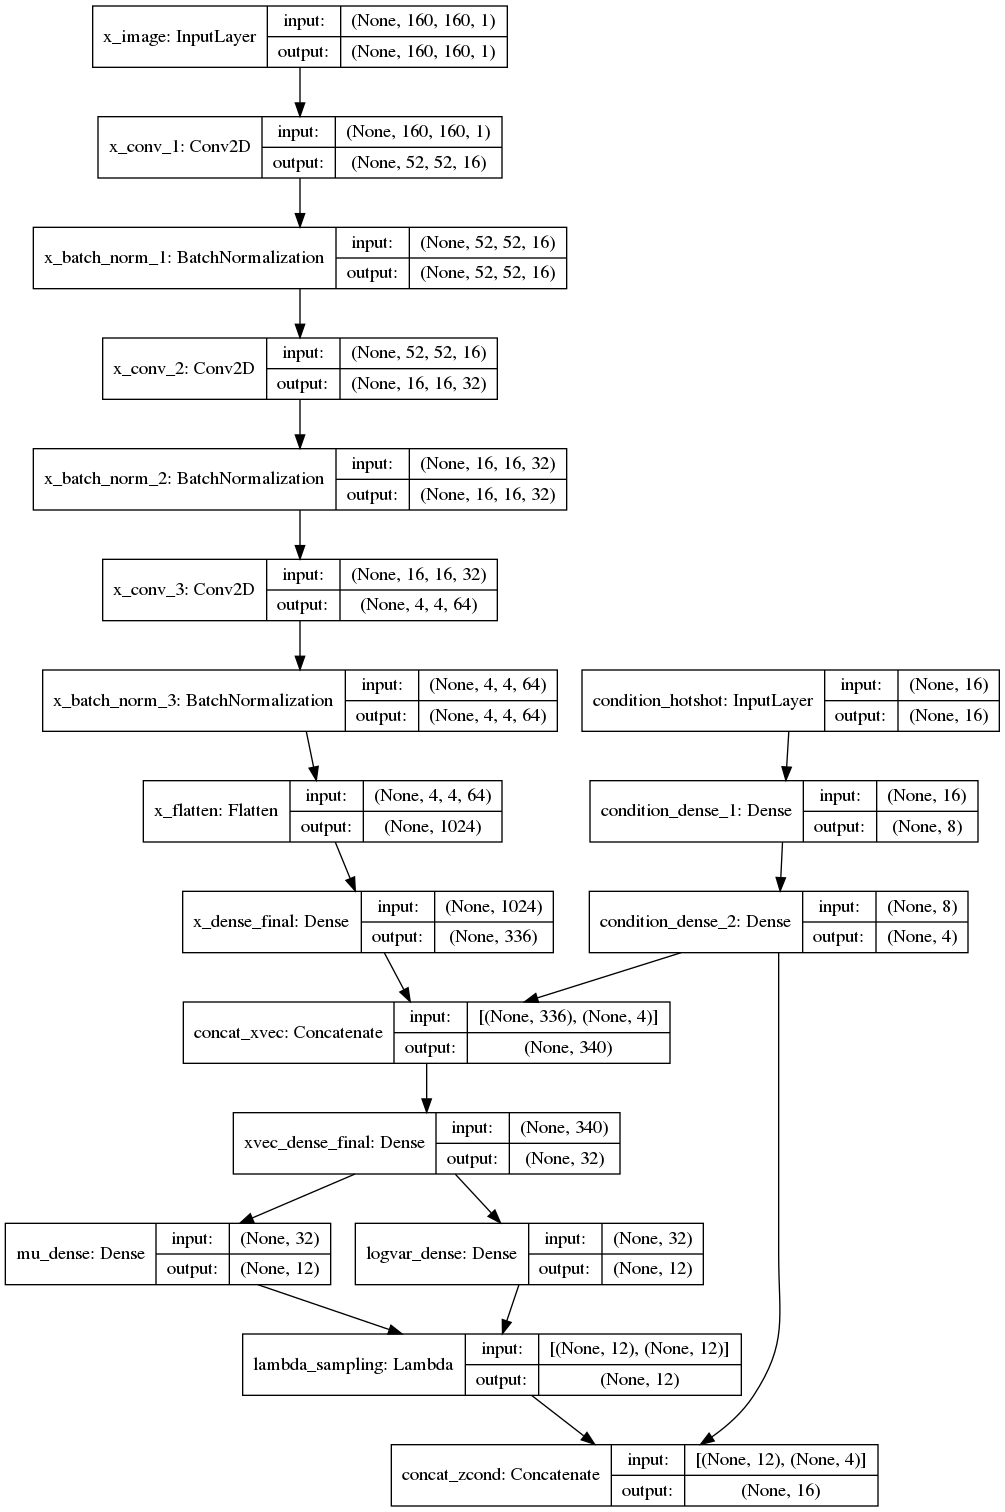

In [8]:
plot_model(CVAE, to_file='CVAE.png', show_shapes=True, show_layer_names=True)
im = Image.open('CVAE.png')
im

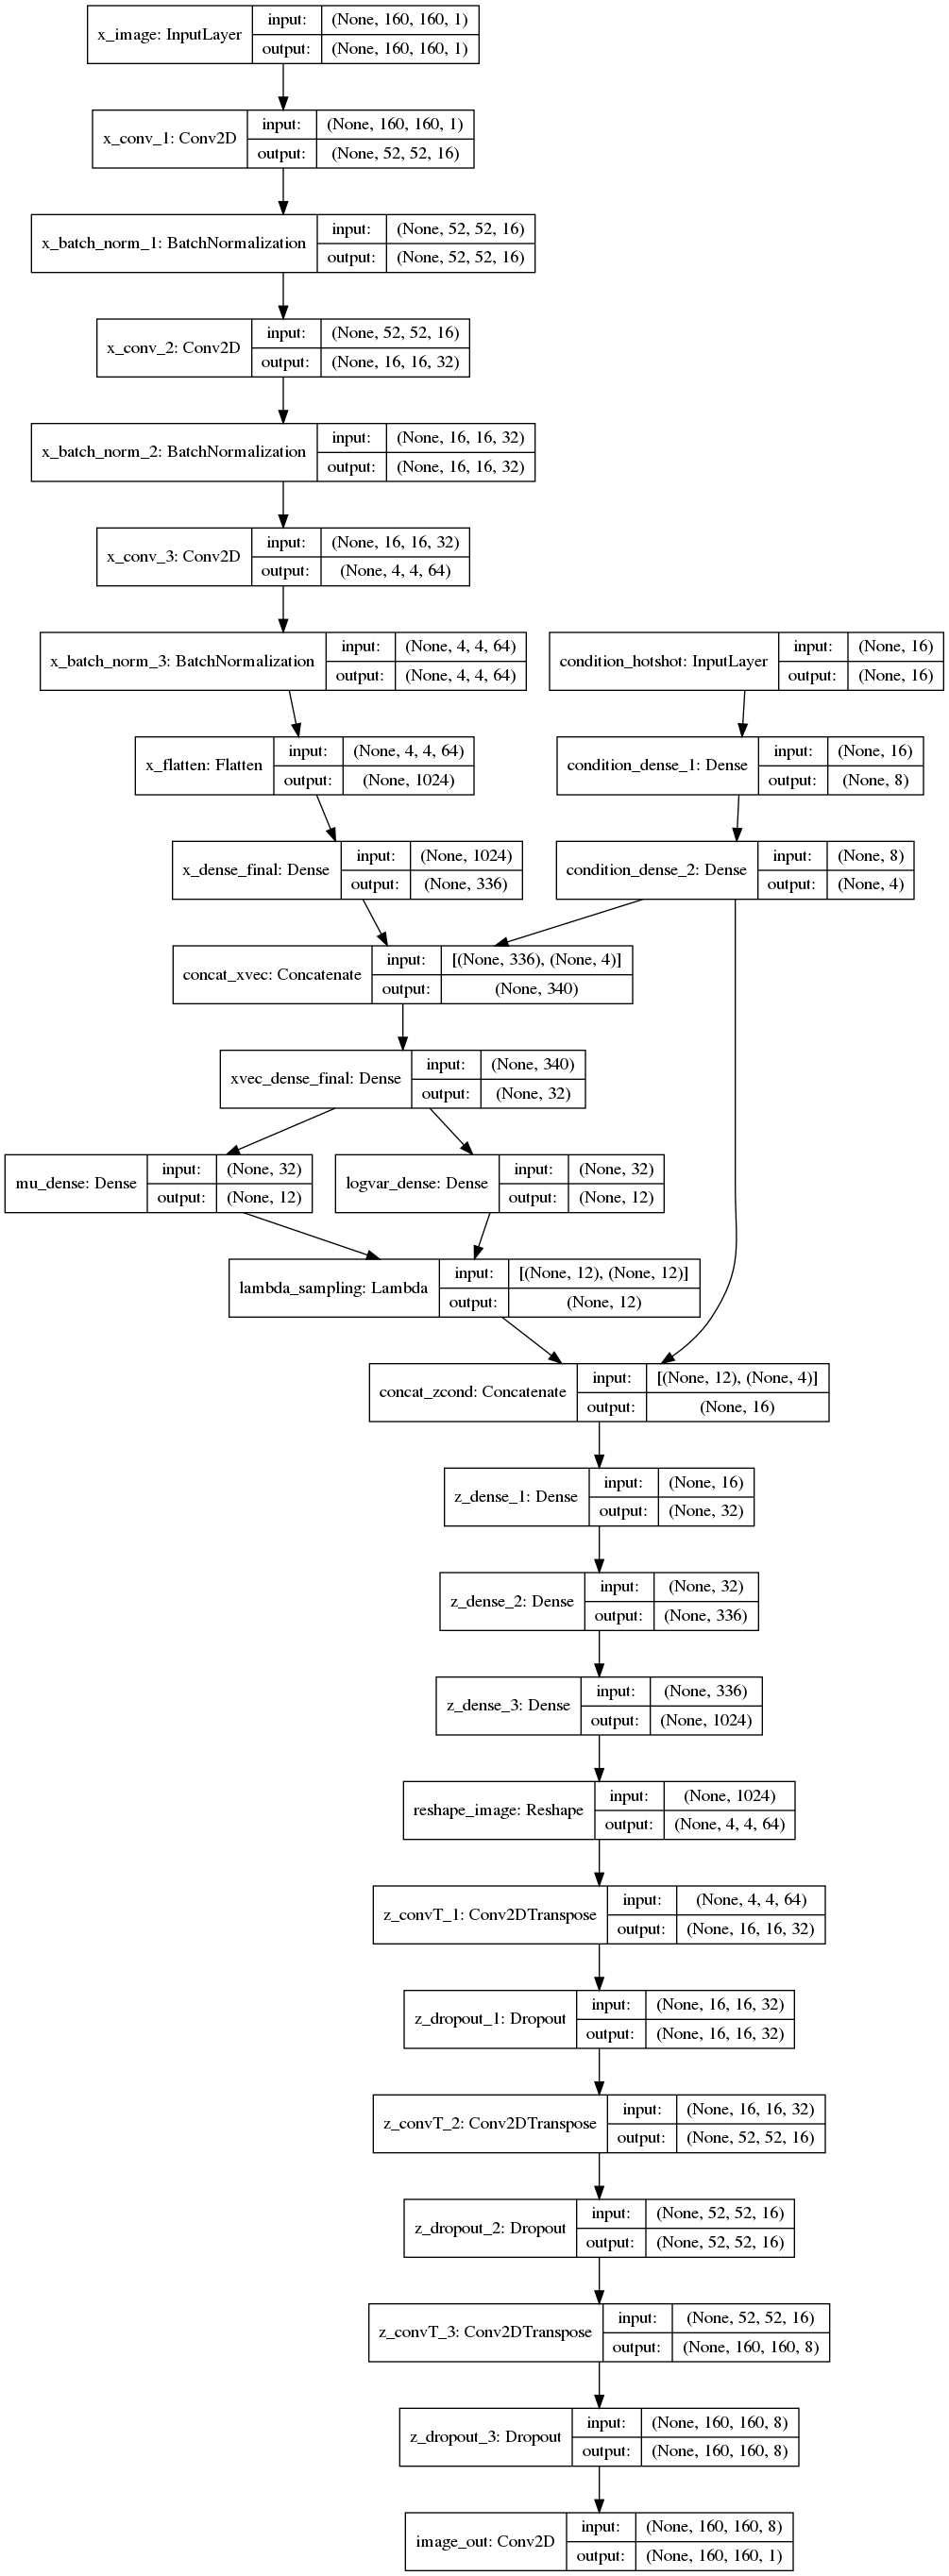

In [9]:
plot_model(CVAE_FULL, to_file='CVAE_FULL.png', show_shapes=True, show_layer_names=True)
im = Image.open('CVAE_FULL.png')
im

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, files, labels, preprocess=None, batch_size = 50, dim=(160,160), n_channels=1, n_classes=16, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.files = files
        self.preprocess = preprocess or (lambda x : x)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        files_temp = [self.files[k] for k in indexes]
        
        X,z = self.__data_generation(files_temp)
        return [X,z], None
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, files_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        z = np.empty((self.batch_size),dtype=int)
        for i,file in enumerate(files_temp):
            X[i,] = cv2.copyMakeBorder(self.preprocess(cv2.imread(file)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(*self.dim, self.n_channels)/255.
            z[i] = self.labels[file]
        return X, keras.utils.to_categorical(z, num_classes=self.n_classes)

In [11]:
labels = gait.fetch_labels(label_angle=angle,save=False,override=True)

100%|██████████| 124/124 [00:09<00:00, 13.09it/s]


In [12]:
files = [filename for filename in labels]

In [13]:
test_files = []
test_partition = np.random.randint(0,len(files),size=3000)
for i in test_partition:
    test_files.append(files[i])
for i in sorted(test_partition)[::-1]:
    del files[i]

In [14]:
train_data = DataGenerator(files,labels,preprocess=gait.preprocess)
valid_data = DataGenerator(test_files, labels, preprocess=gait.preprocess)

In [15]:
'''history = CVAE_FULL.fit_generator(generator=train_data,
                                  validation_data = valid_data,
                                  steps_per_epoch = len(files)//batch_size,
                                  epochs=1,
                                  validation_steps = len(test_files)//batch_size,
                                  use_multiprocessing=True) #,
#                        workers=6)
'''

'history = CVAE_FULL.fit_generator(generator=train_data,\n                                  validation_data = valid_data,\n                                  steps_per_epoch = len(files)//batch_size,\n                                  epochs=1,\n                                  validation_steps = len(test_files)//batch_size,\n                                  use_multiprocessing=True) #,\n#                        workers=6)\n'

In [16]:
len(files)

70266

In [17]:
CVAE_FULL.load_weights('weights/CVAE_FULL.h5')

In [18]:
#CVAE_FULL.save("weights/CVAE_FULL.h5")

In [19]:
imgs = np.empty((50,160,160,1))
z = np.empty((50),dtype=int)
for i,file in enumerate(files[0:50]):
    imgs[i,] = cv2.copyMakeBorder(gait.preprocess(cv2.imread(file)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(160,160,1)/255.
    z[i] = labels[file]
z_vec = keras.utils.to_categorical(z, num_classes=16)
img_predict = CVAE_FULL.predict([imgs,z_vec],batch_size=50)

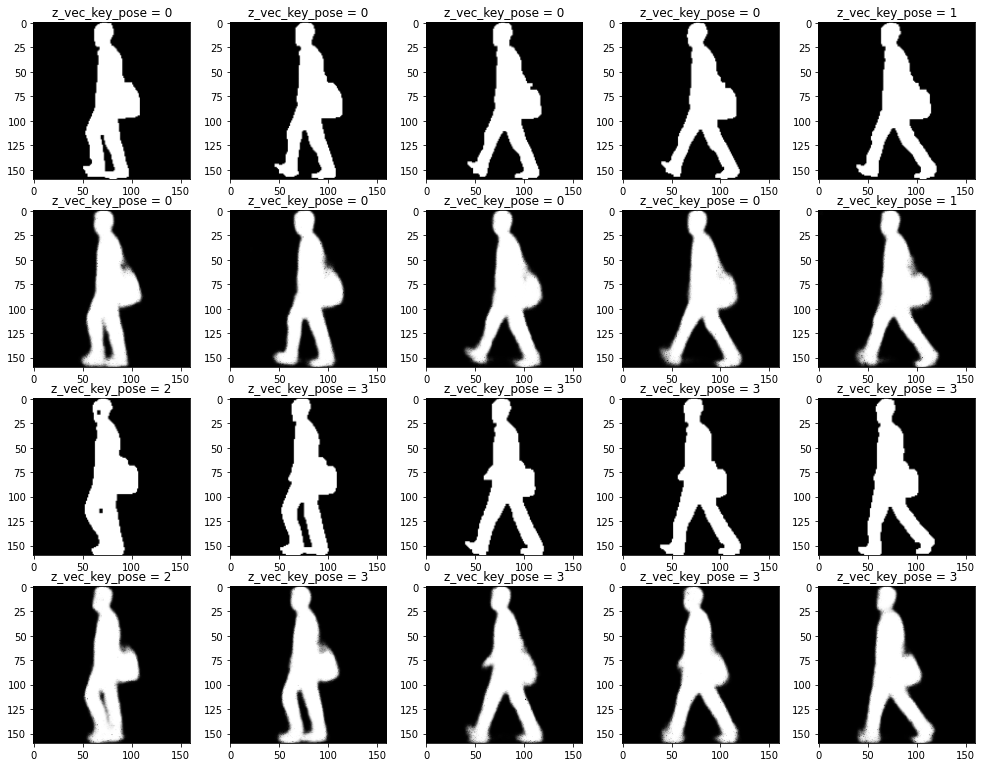

In [20]:
cols = 5
rows = 10
fig = plt.figure(figsize=(17,34))
cnt = 0
for i in range(1 , 21):
    
    ax = fig.add_subplot(rows, cols, i)
    if ((i-1)//5)%2==0:
        ax.set_title('z_vec_key_pose = '+str(z[i-1]))
        plt.imshow(imgs[i+30],cmap='gray')
    else:
        ax.set_title('z_vec_key_pose = '+str(z[i-6]))
        plt.imshow(img_predict[i+25],cmap='gray')
#plt.savefig("AutoEncoders.jpg")
plt.show()

In [21]:
encoder = keras.models.Model(CVAE_FULL.input, CVAE_FULL.get_layer("concat_zcond").output)

In [22]:
enc_vec = encoder.predict([imgs,z_vec],batch_size=50)

In [31]:
temp_lab = list(enumerate(labels))[0:90]
for i,key in temp_lab[0:-3]:
    print(i,"->",labels[key])

0 -> 0
1 -> 0
2 -> 0
3 -> 0
4 -> 1
5 -> 1
6 -> 1
7 -> 1
8 -> 2
9 -> 2
10 -> 2
11 -> 2
12 -> 3
13 -> 3
14 -> 3
15 -> 3
16 -> 4
17 -> 4
18 -> 4
19 -> 5
20 -> 5
21 -> 5
22 -> 5
23 -> 6
24 -> 6
25 -> 6
26 -> 6
27 -> 7
28 -> 7
29 -> 7
30 -> 8
31 -> 8
32 -> 8
33 -> 8
34 -> 8
35 -> 9
36 -> 9
37 -> 9
38 -> 10
39 -> 10
40 -> 10
41 -> 11
42 -> 11
43 -> 11
44 -> 11
45 -> 11
46 -> 12
47 -> 13
48 -> 13
49 -> 13
50 -> 13
51 -> 14
52 -> 14
53 -> 14
54 -> 14
55 -> 15
56 -> 15
57 -> 15
58 -> 15
59 -> 0
60 -> 0
61 -> 0
62 -> 0
63 -> 1
64 -> 1
65 -> 1
66 -> 2
67 -> 2
68 -> 2
69 -> 2
70 -> 3
71 -> 3
72 -> 3
73 -> 3
74 -> 4
75 -> 4
76 -> 4
77 -> 5
78 -> 5
79 -> 5
80 -> 5
81 -> 5
82 -> 6
83 -> 6
84 -> 6
85 -> 6
86 -> 7
